<a href="https://colab.research.google.com/github/TrunnMosby/GSoC-RedHenLabs-Aztec-Glyph-Detection/blob/main/InceptionV3_augmentedimages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import matplotlib.pyplot as plt
import  os
import numpy as np

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt 
import base64
from PIL import Image
import io
import math 
from math import sqrt

In [ ]:
base_models=tf.keras.applications.InceptionV3()

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=base_models.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

shape of x:  (1, 299, 299, 3)
data type:  float32


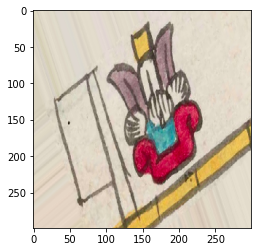

In [ ]:
img, x = load_image("/content/drive/MyDrive/Aztec Glyphs Image Data Set/Augmented images/Acapan20r.jpeg_0_4417.png")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

In [ ]:
predictions = base_models.predict(x)

# print out the 
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))

49152/35363 [=========================================] - 0s 0us/step
predicted flatworm with probability 0.905
predicted clog with probability 0.095
predicted pencil_sharpener with probability 0.000
predicted binoculars with probability 0.000
predicted pitcher with probability 0.000


In [ ]:
base_models.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
feat_extractor = Model(inputs=base_models.input, outputs=base_models.get_layer("avg_pool").output)
feat_extractor.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


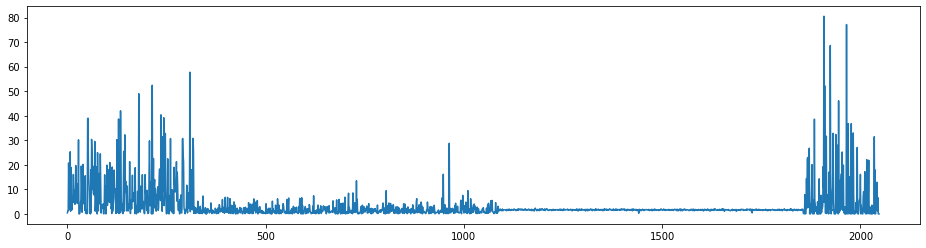

In [ ]:
img, x = load_image("/content/drive/MyDrive/Aztec Glyphs Image Data Set/Augmented images/Acapan20r.jpeg_0_4417.png")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

In [ ]:
images_path = '/content/drive/MyDrive/Aztec Glyphs Image Data Set/Augmented images'
image_extensions = ['.jpg', '.png', '.jpeg']   
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 6473 images to analyze


In [ ]:
import time
tic = time.clock()
features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.clock()
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


analyzing image 0 / 6473. Time: 0.0007 seconds.
analyzing image 500 / 6473. Time: 233.5907 seconds.
analyzing image 1000 / 6473. Time: 234.4062 seconds.
analyzing image 1500 / 6473. Time: 234.2020 seconds.
analyzing image 2000 / 6473. Time: 234.3480 seconds.
analyzing image 2500 / 6473. Time: 235.1009 seconds.
analyzing image 3000 / 6473. Time: 235.9444 seconds.
analyzing image 3500 / 6473. Time: 236.3085 seconds.
analyzing image 4000 / 6473. Time: 236.0409 seconds.
analyzing image 4500 / 6473. Time: 235.6196 seconds.
analyzing image 5000 / 6473. Time: 234.8330 seconds.
analyzing image 5500 / 6473. Time: 233.2323 seconds.
analyzing image 6000 / 6473. Time: 235.3707 seconds.
finished extracting features for 6473 images


In [ ]:
from scipy.spatial import distance

def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(features[query_image_idx], feat) for feat in features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

In [ ]:
def get_closest_images2(query_image_idx, num_results=5):
    distances = [ distance.cosine(features[query_image_idx], feat) for feat in features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return distances

[4467, 1574, 5398, 1029, 2422]
[0.16075623035430908, 0.18267911672592163, 0.17359507083892822, 0.1379888653755188, 0.13719546794891357]
Names of the similar images:-
tlacotl5vosiertwig(SIMPLEX)FromTlacopan5v.jpg_0_991.png
Xocoyocan55r.png_0_8893.png
Apancalecan38r.jpeg_0_8424.png
Tlacopan5vSIMPLEX.jpg_0_6465.png
poloa13rtodestroy(verb)__FromAcapolco.jpeg_0_1592.png


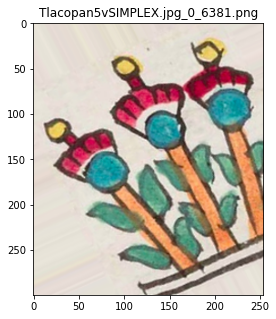

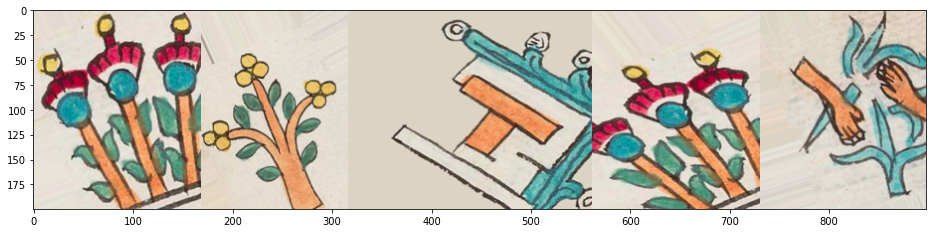

In [ ]:
query_image_idx = 1030
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title(images[query_image_idx].split('/')[-1])
plt.figure(figsize = (16,12))
plt.imshow(results_image)
print(idx_closest)
print(get_closest_images2(query_image_idx)[:5])
print('Names of the similar images:-')
for i in idx_closest:
  print(images[i].split('/')[-1])

[0.15589040517807007, 0.13111138343811035, 0.16658759117126465, 0.12810444831848145, 0.13209158182144165]
Names of the similar images:-
Amaxtlan13rAtlMaxtlatl.jpeg_0_6508.png
Amaxtlan13rAtlMaxtlatl.jpeg_0_9682.png
Huehuetlan47rSIMPLEX.jpeg_0_9361.png
ehuatl40rskin,hideFromEhuacalco.jpeg_0_8964.png
Cillan12rSIMPLEX.jpeg_0_460.png


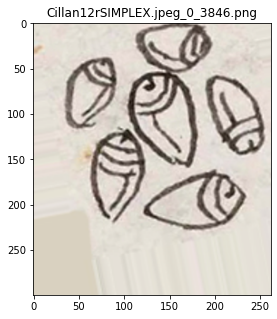

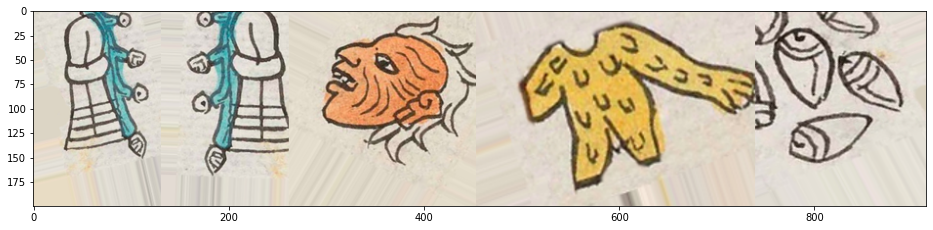

In [ ]:
query_image_idx = 1005
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title(images[query_image_idx].split('/')[-1])
plt.figure(figsize = (16,12))
plt.imshow(results_image)
print(get_closest_images2(query_image_idx)[:5])
print('Names of the similar images:-')
for i in idx_closest:
  print(images[i].split('/')[-1])

Names of the similar images:-
apantli06rwaterchannelFromHuitzitzilapan.jpg_0_8111.png
atl21vwaterFromAcolhuacan.jpg_0_9929.png
yacatl42rnoseFromTepeyacan.jpg_0_2045.png
huitzoctli37rOakPoleForAgric.jpg_0_1499.png
tecihuitl51rhailFromTeciuhtlan.jpg_0_4497.png


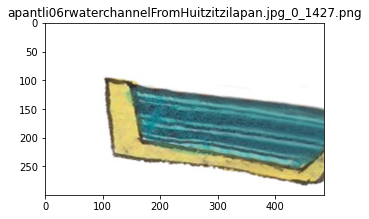

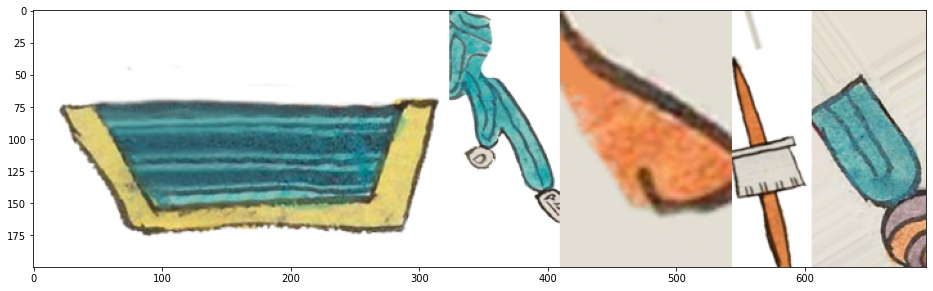

In [ ]:
query_image_idx = 1200
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title(images[query_image_idx].split('/')[-1])
plt.figure(figsize = (16,12))
plt.imshow(results_image)
print('Names of the similar images:-')
for i in idx_closest:
  print(images[i].split('/')[-1])

Names of the similar images:-
Totoltzinco21v.jpeg_0_5175.png
Tezcacoac20v.jpeg_0_275.png
coatl55rserpent,snakeEtzicoac.png_0_6704.png
ichcatl(2)40rcottonSAforIchcatlan.tiff_0_9229.png
Tezcacoac20v.jpeg_0_5393.png


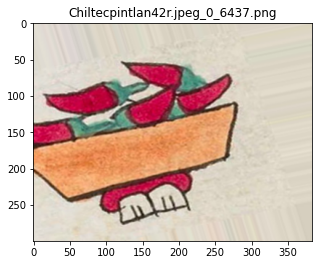

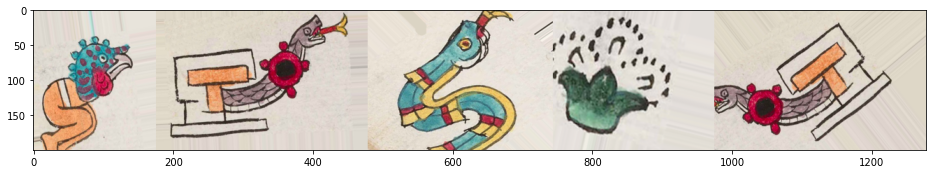

In [ ]:
import random
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title(images[query_image_idx].split('/')[-1])
plt.figure(figsize = (16,12))
plt.imshow(results_image)
print('Names of the similar images:-')
for i in idx_closest:
  print(images[i].split('/')[-1])

Names of the similar images:-
Xoconochco15v.jpeg_0_220.png
Xoconochco47r.jpeg_0_6473.png
tzapotl10vzapotetreeFromTetzapotitlan.jpeg_0_678.png
Xoconochco15v.jpeg_0_4665.png
nochtli15vcactusfruitFromXoconochco.jpg_0_5157.png


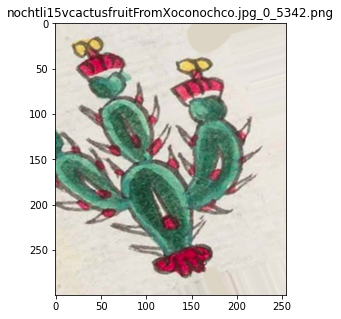

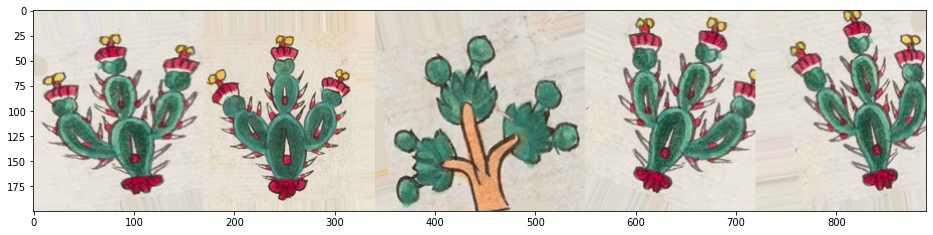

In [ ]:
import random
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title(images[query_image_idx].split('/')[-1])
plt.figure(figsize = (16,12))
plt.imshow(results_image)
print('Names of the similar images:-')
for i in idx_closest:
  print(images[i].split('/')[-1])